In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import sys
sys.path.append('..')
from src.data.dataset_generator import DatasetGenerator
from src.data.data_transformer import DataTransformer

In [2]:
# read data 
dg = DatasetGenerator(['all'])
dataset_latest = dg.get_dataset('2016-01-01', 'latest', 'ignored')

Repaired missing entsoe data from dates: ['2021-08-13']
Data coverage 100%
Data coverage 100%


In [3]:
df = dataset_latest
df

,Time,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
0,2016-01-01 00:00:00,23.86,50211.00,0.0,2275.25,6601.25,5.2,4.9,98.0,0.1,1.4,1026.6,0.0,2.4,2.0,97.0,0.0,6.1,1023.4,0.0
1,2016-01-01 01:00:00,22.39,48192.75,0.0,2285.50,6445.75,4.7,4.6,99.0,0.0,3.2,1026.4,0.0,2.0,2.0,100.0,0.0,9.4,1023.5,0.0
2,2016-01-01 02:00:00,20.59,46264.75,0.0,2228.75,6422.75,3.8,3.7,99.0,0.5,4.3,1026.9,0.0,2.0,2.0,100.0,0.0,9.4,1023.4,0.0
3,2016-01-01 03:00:00,16.81,44942.00,0.0,2011.50,6487.00,4.0,3.9,99.0,0.5,4.0,1027.4,0.0,1.4,1.0,97.0,0.0,9.7,1023.4,0.0
4,2016-01-01 04:00:00,17.41,44431.50,0.0,1942.75,6391.25,4.0,3.9,99.0,0.6,4.0,1027.5,0.0,1.0,0.6,97.0,0.0,7.6,1023.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49243,2021-08-13 19:00:00,117.48,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0
49244,2021-08-13 20:00:00,115.68,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0
49245,2021-08-13 21:00:00,115.77,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0
49246,2021-08-13 22:00:00,106.91,64650.25,30330.0,392.00,1463.00,29.0,16.2,46.0,0.0,13.0,1020.0,0.0,24.3,15.2,57.0,0.0,16.7,1019.2,0.0


# Plot the data (use for report)

Text(0.5, 0, 'time')

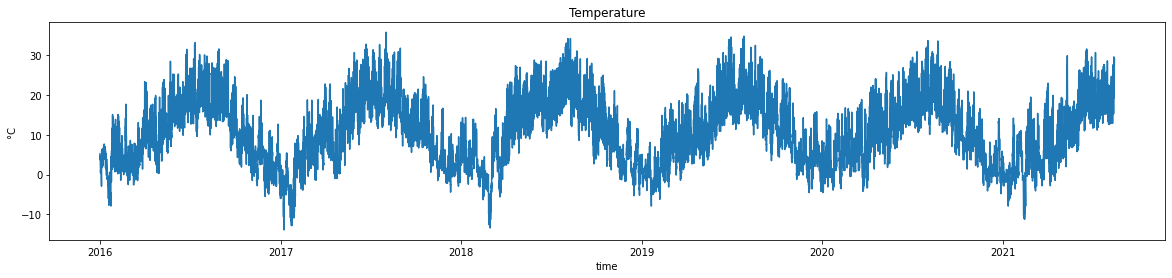

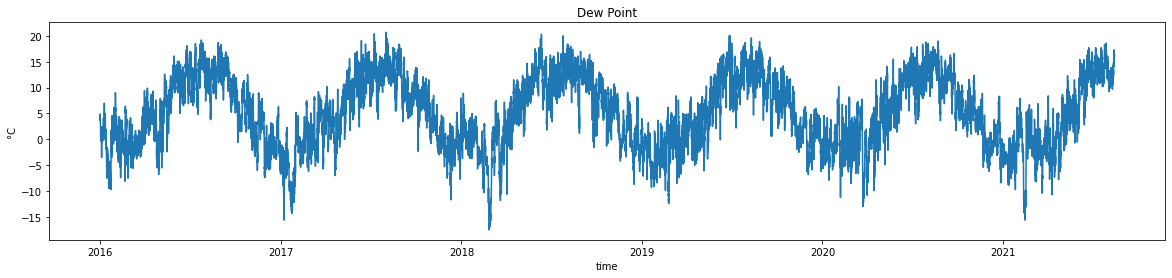

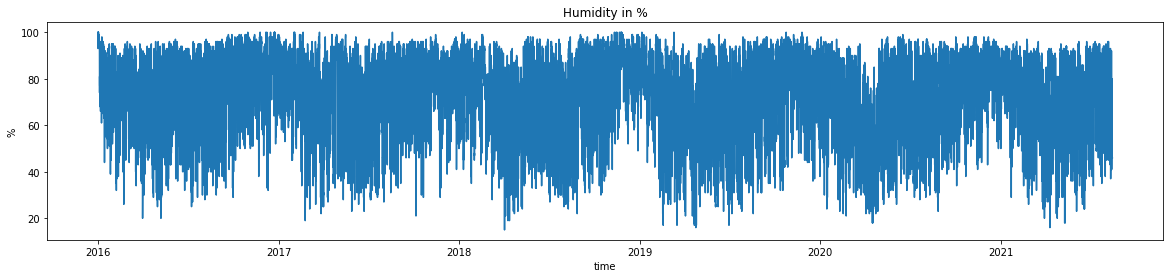

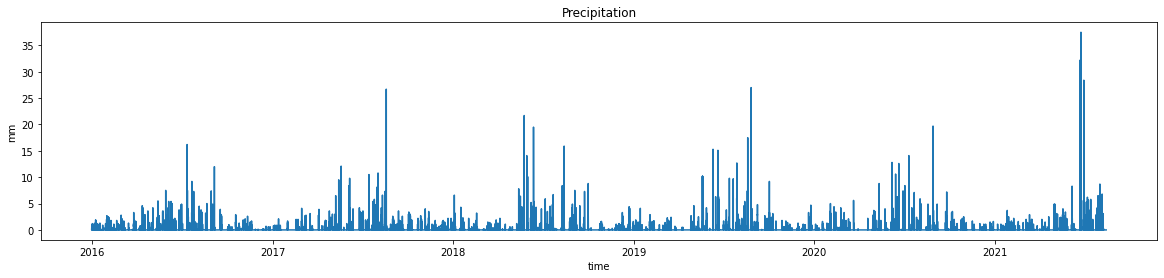

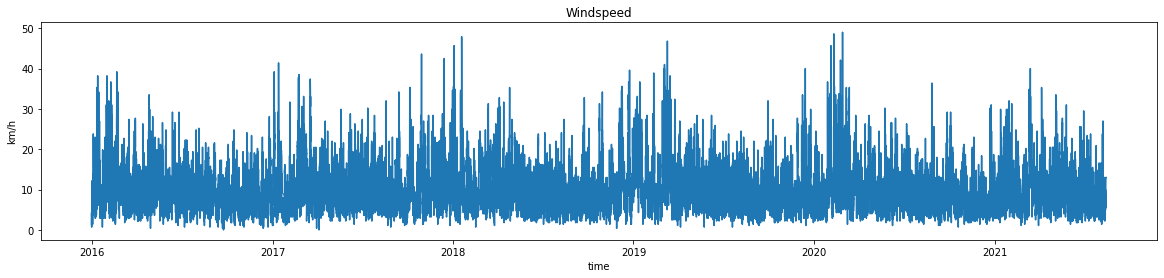

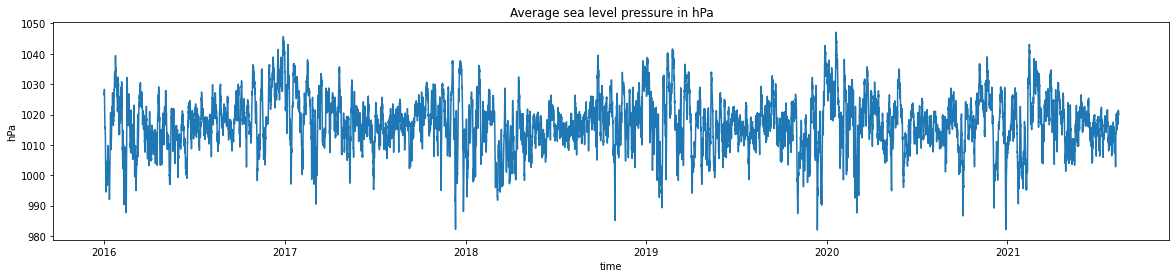

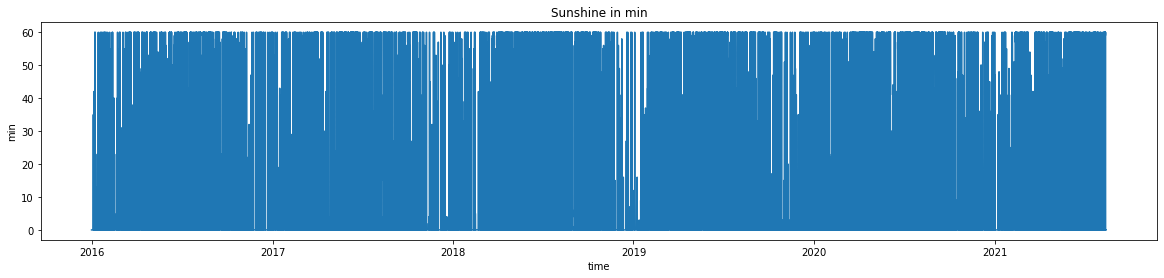

In [4]:
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['temp_muc'])
plt.title('Temperature')
plt.ylabel('°C')
plt.xlabel('time')
#plt.savefig('Temp data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['dwpt_muc'])
plt.title('Dew Point')
plt.ylabel('°C')
plt.xlabel('time')
#plt.savefig('Dew data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['rhum_muc'])
plt.title('Humidity in %')
plt.ylabel('%')
plt.xlabel('time')
#plt.savefig('Hum data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['prcp_muc'])
plt.title('Precipitation')
plt.ylabel('mm')
plt.xlabel('time')
#plt.savefig('Pre data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'],df['wspd_muc'])
plt.title('Windspeed')
plt.ylabel('km/h')
plt.xlabel('time')
#plt.savefig('Windspeed data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['pres_muc'])
plt.title('Average sea level pressure in hPa')
plt.ylabel('hPa')
plt.xlabel('time')
#plt.savefig('Sea level gust data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['tsun_muc'])
plt.title('Sunshine in min')
plt.ylabel('min')
plt.xlabel('time')
#plt.savefig('Sunshine data')


Text(0.5, 0, 'time')

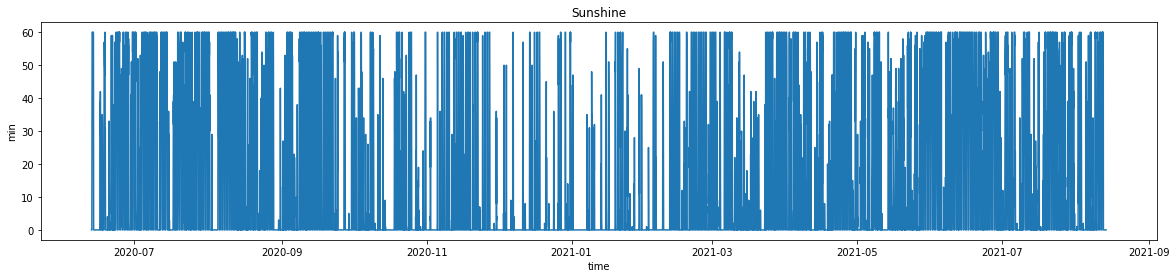

In [5]:
plt.figure(figsize = (20, 4))
plt.plot(df['Time'][39000:], df['tsun_muc'][39000:])
plt.title('Sunshine')
plt.ylabel('min')
plt.xlabel('time')
#plt.savefig('sunshine on year seasonality')

Text(0.5, 0, 'time')

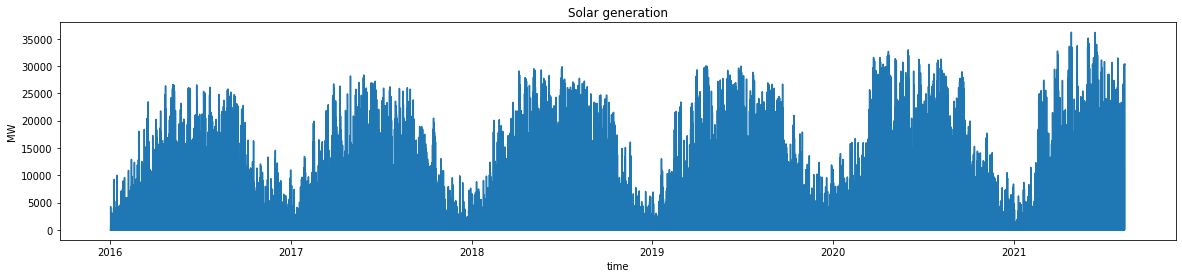

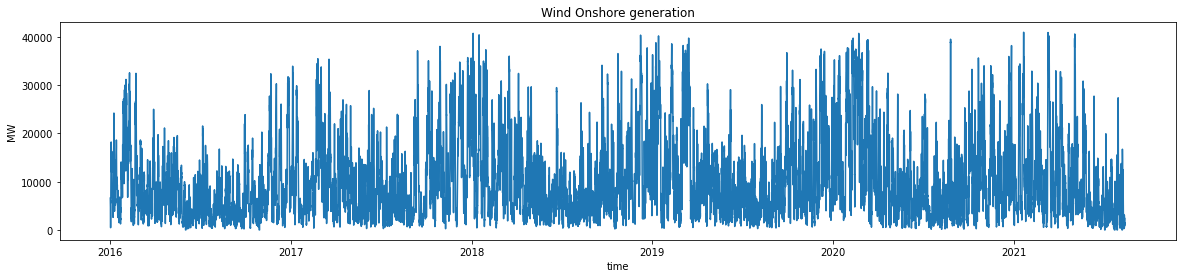

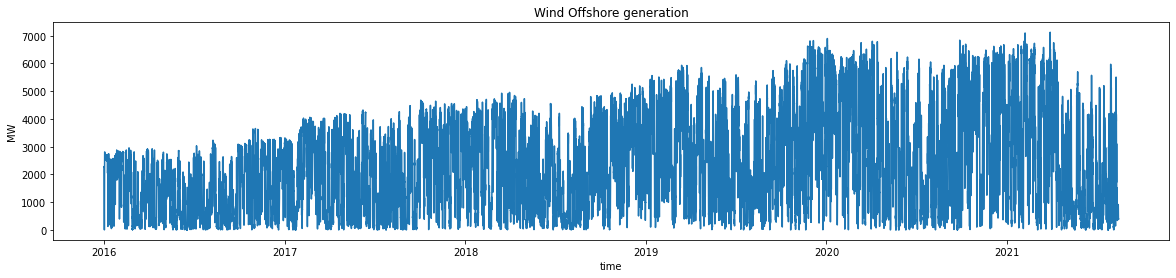

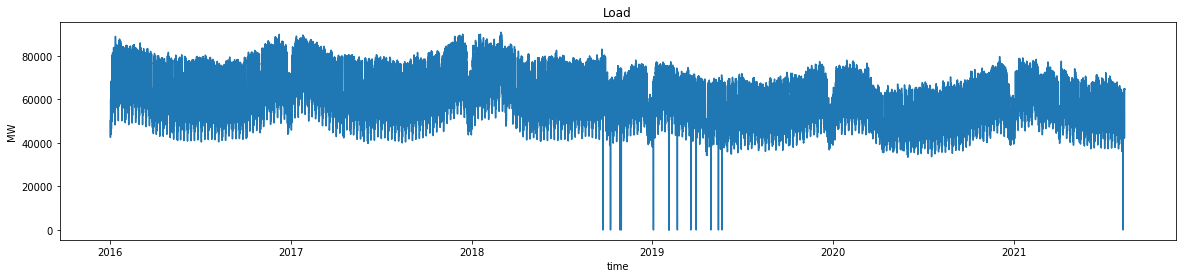

In [6]:
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['Solar'])
plt.title('Solar generation')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Solar data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['Wind Onshore'])
plt.title('Wind Onshore generation')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Wind Onshore generation data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['Wind Offshore'])
plt.title('Wind Offshore generation')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Wind Offshore generation data')
plt.figure(figsize = (20, 4))
plt.plot(df['Time'], df['Load'])
plt.title('Load')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Load data')

# Check for correlations

In [7]:
overall_pearson_r = df.corr()
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df.dropna()['Value'], df.dropna()['snow'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df['Value'].rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Pandas computed Pearson r:                SPOTPrice      Load     Solar  Wind Offshore  Wind Onshore  \
SPOTPrice       1.000000  0.302281 -0.043240      -0.213541     -0.393944   
Load            0.302281  1.000000  0.252635      -0.009435      0.083011   
Solar          -0.043240  0.252635  1.000000      -0.145658     -0.184293   
Wind Offshore  -0.213541 -0.009435 -0.145658       1.000000      0.647064   
Wind Onshore   -0.393944  0.083011 -0.184293       0.647064      1.000000   
temp_muc       -0.030785 -0.088725  0.506497      -0.201591     -0.234580   
dwpt_muc        0.034086 -0.232400  0.191095      -0.234979     -0.292685   
rhum_muc        0.100018 -0.202421 -0.604290      -0.001311     -0.038538   
prcp_muc        0.019958 -0.022688 -0.034452      -0.018182     -0.002596   
wspd_muc       -0.206342  0.178020  0.109843       0.151327      0.460491   
pres_muc        0.067342  0.000977 -0.052039       0.016420     -0.075895   
tsun_muc       -0.011259  0.208213  0.662989     

KeyError: 'Value'